In [3]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Try to import XGBoost, install if not available
try:
    from xgboost import XGBRegressor
    xgboost_available = True
except ModuleNotFoundError:
    print("XGBoost not found. Installing...")
    !pip install xgboost
    from xgboost import XGBRegressor
    xgboost_available = True

# Try to import SHAP, install if not available
try:
    import shap
    shap_available = True
except ModuleNotFoundError:
    print("SHAP not found. Installing...")
    !pip install shap
    import shap
    shap_available = True

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

XGBoost not found. Installing...
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.5/56.8 MB 1.3 MB/s eta 0:00:44
    --------------------------------------- 0.8/56.8 MB 1.4 MB/s eta 0:00:41
    --------------------------------------- 1.3/56.8 MB 1.7 MB/s eta 0:00:34
   - -------------------------------------- 1.8/56.8 MB 1.8 MB/s eta 0:00:31
   - -------------------------------------- 2.1/56.8 MB 1.9 MB/s eta 0:00:29
   -- ------------------------------------- 2.9/56.8 MB 2.1 MB/s eta 0:00:27
   -- ------------------------------------- 3.4/56.8 MB 2.1 MB/s eta 0:00:25
   -- ------------------------------------- 3.9/56.8 MB 2.3 MB/s eta 0:00:24
   --- ------------------------------------ 4.7/56.8 MB 2.4 MB/s eta 0:00:23
   --- ------------------------------------ 5.2/56.8 MB 2.4 MB/s

In [6]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Model Interpretation
import shap

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Load the training and test data
train_df = pd.read_csv('train.csv') # Make sure the file path is correct!
test_df = pd.read_csv('test_expanded.csv')

# Display the first few rows of the training data
print("Training Data Shape:", train_df.shape)
train_df.head()

Training Data Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


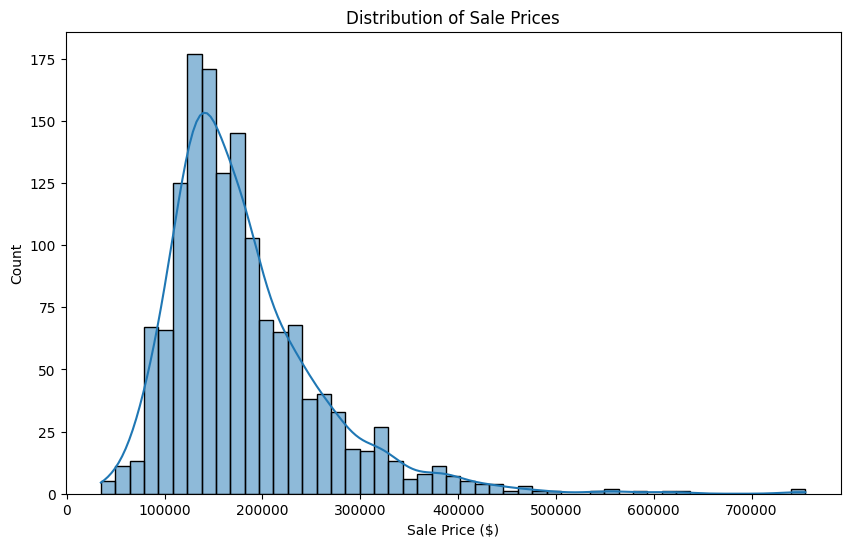

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Skewness: 1.882876


In [7]:
# 1. Distribution of the Target Variable 'SalePrice'
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price ($)')
plt.show()

# It's right-skewed. Let's check the statistics.
print(train_df['SalePrice'].describe())
print("\nSkewness: %f" % train_df['SalePrice'].skew())

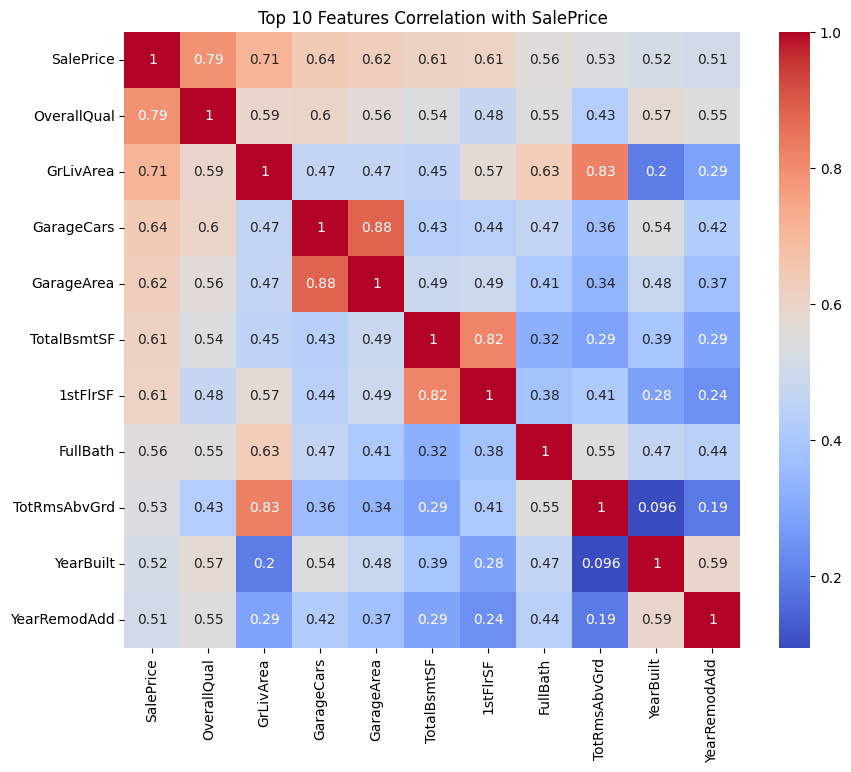

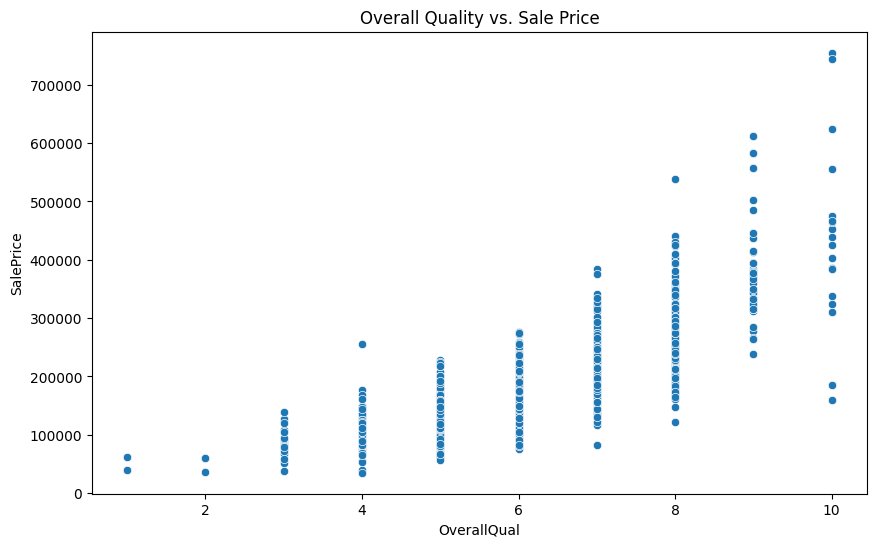

In [8]:
# 2. Correlation Heatmap for Numerical Features
# Select only numerical columns
numeric_features = train_df.select_dtypes(include=[np.number])
# Calculate correlation matrix
corr_matrix = numeric_features.corr()
# Plot heatmap of top 10 features correlated with SalePrice
top_corr_features = corr_matrix['SalePrice'].sort_values(ascending=False).head(11).index
top_corr_matrix = train_df[top_corr_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Top 10 Features Correlation with SalePrice')
plt.show()

# 3. Scatter plot between the most correlated feature and SalePrice
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_df['OverallQual'], y=train_df['SalePrice'])
plt.title('Overall Quality vs. Sale Price')
plt.show()

In [9]:
# Separate features and target for training data
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=[np.number]).columns

# Check for missing values
missing_values = X.isnull().sum().sort_values(ascending=False)
missing_values_percent = (X.isnull().sum() / X.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing_values, missing_values_percent], axis=1, keys=['Total', 'Percent'])
print("Missing Data Overview:")
print(missing_data.head(20)) # Show top 20 columns with most missing values

# Based on the data description from Kaggle, we can make decisions on how to handle missing values.
# For example, 'PoolQC' (Pool Quality) has >99% missing. We can likely drop this column.
# For other columns, we will impute.

# Let's create lists of columns to drop and columns to impute.
cols_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']
# Note: This is a simplified approach. A more robust project would go through each feature individually based on its data description.

# Imputation strategy:
# For numerical: Impute with median
# For categorical: Impute with mode (most frequent category)

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

Missing Data Overview:
              Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
MasVnrType      872  0.597260
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageCond       81  0.055479
GarageType       81  0.055479
GarageYrBlt      81  0.055479
GarageQual       81  0.055479
GarageFinish     81  0.055479
BsmtFinType2     38  0.026027
BsmtExposure     38  0.026027
BsmtFinType1     37  0.025342
BsmtCond         37  0.025342
BsmtQual         37  0.025342
MasVnrArea        8  0.005479
Electrical        1  0.000685
BedroomAbvGr      0  0.000000


In [10]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a function to evaluate models
def evaluate_model(model, X_train, X_valid, y_train, y_valid):
    # Create a pipeline with preprocessor and model
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    # Fit the model
    my_pipeline.fit(X_train, y_train)
    # Predict
    preds = my_pipeline.predict(X_valid)
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    r2 = r2_score(y_valid, preds)
    return rmse, r2, my_pipeline

# Let's try a few models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1)
}

results = {}
trained_pipelines = {}

for name, model in models.items():
    rmse, r2, pipeline = evaluate_model(model, X_train, X_valid, y_train, y_valid)
    results[name] = {'RMSE': rmse, 'R2 Score': r2}
    trained_pipelines[name] = pipeline
    print(f"{name}: RMSE = {rmse:.2f}, R2 = {r2:.4f}")

# Compare results
results_df = pd.DataFrame(results).T
results_df.sort_values(by='RMSE')

Linear Regression: RMSE = 29476.18, R2 = 0.8867
Ridge: RMSE = 29844.25, R2 = 0.8839
Random Forest: RMSE = 28527.52, R2 = 0.8939
XGBoost: RMSE = 25568.03, R2 = 0.9148


,RMSE,R2 Score
XGBoost,25568.028580,0.914772
Random Forest,28527.520338,0.893900
Linear Regression,29476.184616,0.886726
Ridge,29844.251463,0.883880


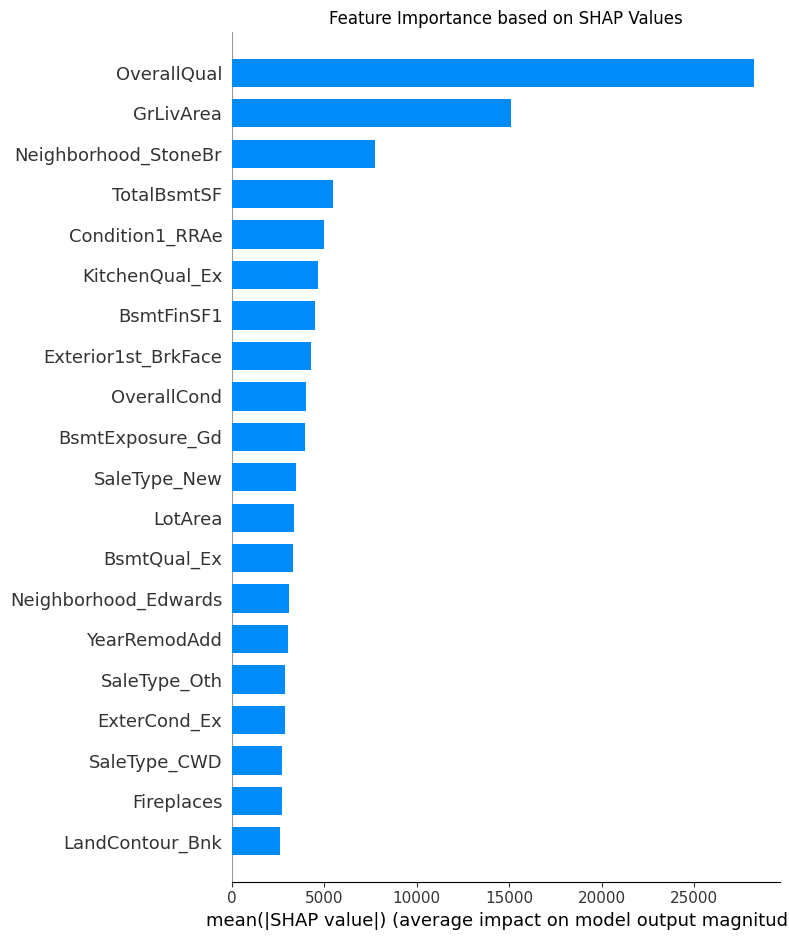

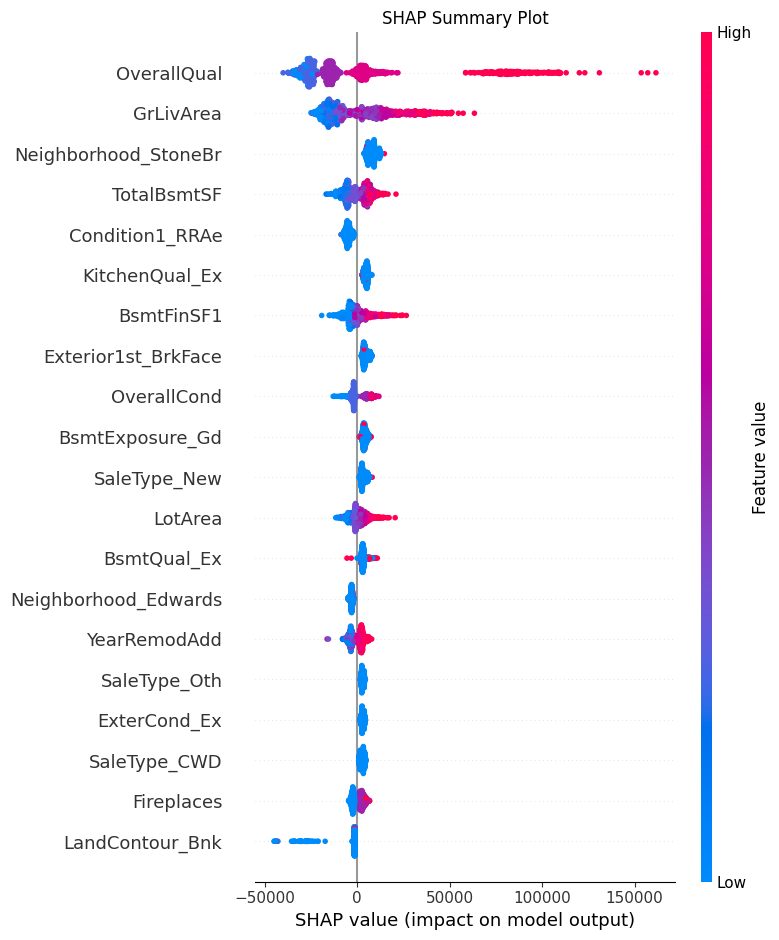

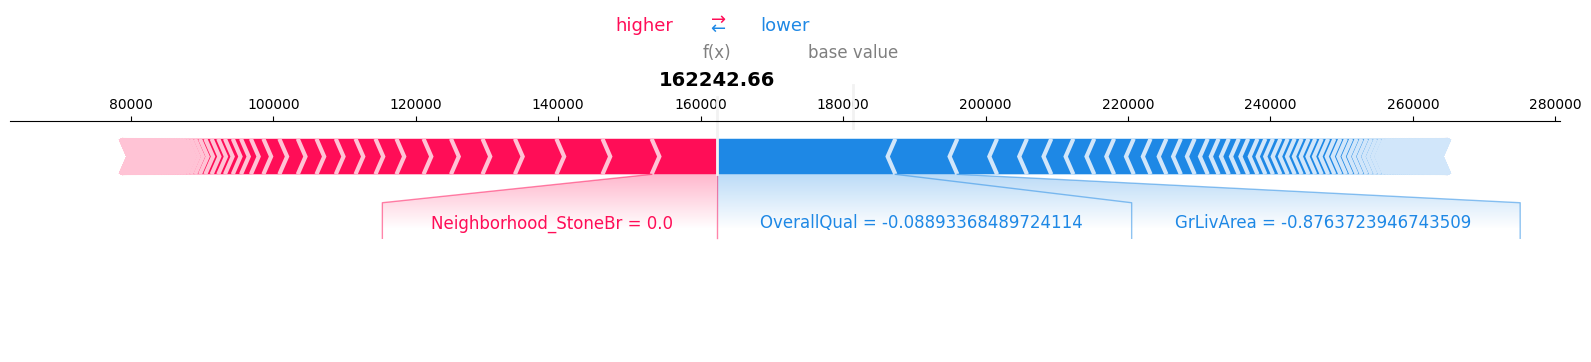

In [11]:
# Let's use the best model, e.g., XGBoost
best_pipeline = trained_pipelines['XGBoost']

# We need to get the preprocessed feature names for SHAP
# Get the preprocessor from the pipeline
preprocessor = best_pipeline.named_steps['preprocessor']
# Fit the preprocessor on the full training data to get all feature names
preprocessor.fit(X_train)
# Get feature names after one-hot encoding
ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
# Combine all feature names
feature_names = np.append(numerical_cols, ohe_feature_names)

# Now we extract the trained model from the pipeline
model = best_pipeline.named_steps['model']

# To explain the model, we need to create a sample of the preprocessed data
X_processed = preprocessor.transform(X_train) # This is a sparse matrix
X_processed_df = pd.DataFrame(X_processed.toarray(), columns=feature_names) # Convert to DataFrame for SHAP

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model)
# Calculate SHAP values (this might take a minute)
shap_values = explainer.shap_values(X_processed_df)

# 1. Summary Plot (Feature Importance)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_processed_df, plot_type="bar", show=False)
plt.title('Feature Importance based on SHAP Values')
plt.tight_layout()
plt.show()

# 2. Summary Plot for a single prediction
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_processed_df, show=False)
plt.title('SHAP Summary Plot')
plt.tight_layout()
plt.show()

# 3. Force plot for a specific observation (e.g., the first house in the validation set)
# Preprocess the validation set
X_valid_processed = preprocessor.transform(X_valid)
X_valid_processed_df = pd.DataFrame(X_valid_processed.toarray(), columns=feature_names)
# Choose an observation to explain
observation_idx = 0
shap.force_plot(explainer.expected_value, shap_values[observation_idx,:], X_valid_processed_df.iloc[observation_idx,:], matplotlib=True)